In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astrodendro
import os
from astropy import wcs
from astrodendro import Dendrogram, pp_catalog
from astrodendro.analysis import PPStatistic
from astropy.table import Table, hstack, Column
from astropy.utils.console import ProgressBar
import reproject
import pyregion
import astropy.wcs as wcs

print(np.__version__)

1.16.5


In [2]:
####################################################################################################
### Image information and assumptions
####################################################################################################

distance        = 8340. # distance to GC; Reid et al. 2014
#Temp            = 20.0
Wave            = (3.0e8/226.e9)
Wave0           = 1.3e-3
k0              = 0.899
nu              = 3.e08/Wave
nu0             = 3.e08/Wave0
beta            = 1.75
Kappag2d        = k0*((nu/nu0)**beta)
g2d             = 100.0
Kappa           = Kappag2d / g2d
mu              = 2.8 # express everything in H2

dustTemp = 20

# Constants
G = 6.67408e-11
msun = 1.989e33
mh = 1.6737236e-27
pc2cm = 3.08567758e18
as2persr = 4.25e10 
percm2perm = 1.0e6
JyperSr_to_JyperPix = (3.0462*(10**-4))*((0.00013888888888)**2)
JyperSr_to_Jyperassqr = ((np.pi*180.)**(-2))*(3600**(-1))
hplanck = 6.63e-34
clight = 2.99792e8
kboltzmann = 1.381e-23
sin1yr = 3.15569e7
arcsec2pc = distance/((360./(2.*np.pi))*60.*60.)

### Define physical property functions

def planck_wave( Wave, Temp ):

    # Planck function using wavelength

    planck_conv_wave = 1.e-26 * clight / Wave**2.0

    planck = ((2.0*hplanck*clight**2.0)/(Wave**5.0))*(1.0/(np.exp((hplanck*clight)/(Wave*kboltzmann*Temp))-1.0))
    planck = planck/planck_conv_wave

    return planck

def mass_calc_submm( Wave, Temp, Kappa, Integrated_Flux, Obj_Dist ):

    Obj_Dist = Obj_Dist * pc2cm
    #from planck_func import planck_wave
    B = planck_wave( Wave, Temp )
    Mass = (Obj_Dist**2. * Integrated_Flux) / ( Kappa * B )
    Mass = Mass / msun
    return Mass

def column_density(Wave, Temp, Kappa, Flux, mu):

    #from planck_func import planck_wave

    B = planck_wave( Wave, Temp )

    N = Flux / (mu * (mh*1.e3) * Kappa * B)

    return N

def number_density_sphere_pc( Mass_sol, Radius_pc, mu ):

    # This subroutine accepts mass in solar masses and radius in pc and calculates the number density.

    Mass = Mass_sol * (msun/1000.0)
    Radius = Radius_pc * (pc2cm/100.0)

    n = Mass / (((4. / 3.)*np.pi) * mu * mh * Radius**3.0)

    # Convert to particles per cubic centimetre

    n = n / percm2perm

    return n

def mass_density_sphere( Mass_sol, Radius_pc ):

    # This subroutine accepts mass in solar masses and radius in pc and calculates the mass density.

    Mass = Mass_sol * (msun/1000.0)
    Radius = Radius_pc * (pc2cm/100.0)

    rho = Mass / (((4. / 3.)*np.pi) * Radius**3.0)

    return rho

def tff_spherical( number_density, mu ):

    # Accepts a number density in units of particles per cubic centimetre and derives the free fall time in yrs

    mass_density = mu * mh * number_density * percm2perm

    tff = np.sqrt( (3. * np.pi) / (32. * G * mass_density) )

    tff = tff / sin1yr # free-fall time in years

    return tff

In [7]:
####################################################################################################
### define function for initial catalog table
####################################################################################################

def run_characterization(Target, DStructure, final_noisemap,pp,pm,filesuffix, path):
    InputMap = fits.open(Target+'.fits')[0]
    
    HeaderMod = InputMap.header.copy()
    #print HeaderMod

    PixelAreaArcsec = 3600. * abs(InputMap.header['CDELT1']) * 3600. * abs(InputMap.header['CDELT2'])
    #Compile Metadata
    Metadata = {}
    Metadata['data_unit'] = u.Jy / u.sr
    Metadata['spatial_scale'] =  PixelAreaArcsec**0.5 * u.arcsec

    Metadata['wcs'] = wcs.WCS(header=HeaderMod).celestial
    #Actually build the catalog from the initial dendrogram
    Catalogue = astrodendro.pp_catalog(DStructure, Metadata)
    #Customize catalog with units and coordinate system
    Catalogue['x_cen'].unit = u.deg
    Catalogue['y_cen'].unit = u.deg
    Catalogue.rename_column('_idx', 'index')
    Catalogue.rename_column('flux', 'flux_integrated')
    Catalogue.rename_column('x_cen', 'glon')
    Catalogue.rename_column('y_cen', 'glat')
    Catalogue['flux_integrated'].unit = u.Jy
    Catalogue['flux_integrated'] = Catalogue['flux_integrated']
    Catalogue['r_eff'] = (Catalogue['area_exact']/np.pi)**0.5
    Catalogue['r_eff'].unit = u.arcsec
    Catalogue['glon'].unit = u.deg
    Catalogue['glat'].unit = u.deg
    
    # add a 'noise' column to the catalog
    keys = ['testflux_integrated', 'flux_integrated_bgsub','min_flux_integrated', 'noise', 'is_leaf', 'peak_cont_flux', 'min_cont_flux', 'mean_cont_flux','npix']
    columns = {k:[] for k in (keys)}
    
    for ii, row in enumerate(ProgressBar(Catalogue)):
        structure = dend[row['index']]
        assert structure.idx == row['index'] == ii
        dend_inds = structure.indices()
        columns['noise'].append(final_noisemap[dend_inds].mean())
        columns['is_leaf'].append(structure.is_leaf)
        peakflux = data[dend_inds].max()
        testflux = np.nansum(data[dend_inds])
        testflux_integrated = testflux*JyperSr_to_JyperPix
        minflux = data[dend_inds].min()
        numpix = np.shape(dend_inds)[1]
        backgroundflux = minflux*numpix*JyperSr_to_JyperPix
        columns['flux_integrated_bgsub'].append(Catalogue['flux_integrated'][ii] - backgroundflux)
        columns['peak_cont_flux'].append(peakflux)
        columns['min_cont_flux'].append(data[dend_inds].min())
        columns['mean_cont_flux'].append(data[dend_inds].mean())
        columns['npix'].append(numpix)
        columns['min_flux_integrated'].append(backgroundflux)
        columns['testflux_integrated'].append(testflux_integrated)
        
    for k in columns:
        if k not in Catalogue.keys():
            Catalogue.add_column(Column(name=k, data=columns[k]))
    
    Catalogue['peak_cont_flux'].unit = u.Jy / u.sr
    Catalogue['mean_cont_flux'].unit = u.Jy / u.sr
    Catalogue['mean_cont_flux'].unit = u.Jy / u.sr
    
    #pruning
    print("Pruning...")
    cat_mask = (Catalogue['is_leaf'] &
                (Catalogue['peak_cont_flux']>pp*Catalogue['noise']) &
                (Catalogue['mean_cont_flux']>pm*Catalogue['noise']))
    pruned_ppcat = Catalogue[cat_mask]
    mask = dend.index_map.copy()
    for ii in ProgressBar(list(range(len(Catalogue)))):
        if ii not in pruned_ppcat['index']:
            mask[mask == ii] = -1
    print(mask.shape)
    print(mask)
    outf = fits.PrimaryHDU(data=mask, header=HeaderMod)
    print(outf)
    print("Writing mask file...")
    outf.writeto(path+'dendrogram_mask_pruned'+filesuffix+'.fits', overwrite=True)
    
    print("Writing region file...")
    with open(path+"raw_dendrogram_cores"+filesuffix+".reg", 'w') as fh:
        fh.write("galactic\n")
        for row in pruned_ppcat:
            fh.write("ellipse({glon}, {glat}, {major_sigma}\", "
                     "{minor_sigma}\", {position_angle}) # text={{{index}}}\n"
                     .format(**dict(zip(row.colnames, row))))
        
    print("Region file complete!")
    
    print("Writing data table...")        
    OutputPath = path + 'catalog'+'_datatab'+filesuffix+'.fits'
    if os.path.isfile(OutputPath):
        os.remove(OutputPath)
    pruned_ppcat.write(OutputPath,
                    format='fits')
    print("Data table written!")
    

In [10]:
####################################################################################################
### PREP THE CATALOG
####################################################################################################

JyperSr_to_JyperPix = (3.0462*10**(-4))*((0.00013888888888)**2)

#ASSIGN PARAMETERS

rms = 3.0e6 #1*10**7
dend_min_v = 3
dend_min_d = 1
dend_min_pix = 17
prune_min_peak = 4
prune_min_mean = 2


date = '_10-21-19'
#directory = '/Users/hph/Dropbox/CMZoom_Data/continuum_images/'
directory = '/Users/hph/cmzoom_catalog/catalog_complete/'
target = directory+'CMZoom_continuum_mosaic_without_sgra_pb_corrected_new'
filesuffix = '_rms3e6_dv'+str(dend_min_v)+'_dd'+str(dend_min_d)+'_dp'+str(dend_min_pix)+'_pp'+str(prune_min_peak)+'_pm'+str(prune_min_mean)+'_gal'+date


sma = fits.open(directory + 'CMZoom_continuum_mosaic_without_sgra_pb_corrected_new.fits')
data = sma[0].data
HeaderMod = sma[0].header

#print data.shape

mywcs = wcs.WCS(HeaderMod)

In [11]:
####################################################################################################
### RUN THE CATALOG
####################################################################################################

 #2.5*10**6

print( "Running dendrogram...")
dend = astrodendro.Dendrogram.compute(data, min_value=float(dend_min_v)*rms, min_delta=float(dend_min_d)*rms,
                                      min_npix=dend_min_pix,
                                      wcs=mywcs)
print("Dendrogram complete!")
#Save the dendrogram to the working directory (temporary)
dend.save_to(directory+'/prototype_dendrogram'+filesuffix+'.fits')

noisemap = fits.open(directory+'CMZoom_noisemap_JySr_k14_final.fits')
noisemap_data = noisemap[0].data 
print( "Running characterization...")
#Perform pruning and save catalog to working directory (temporary)
run_characterization(target,dend,noisemap_data,
                     float(prune_min_peak),float(prune_min_mean),filesuffix,path=directory)
print("Characterization complete!")



Running dendrogram...


/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astrodendro/dendrogram.py:177: RuntimeWarning: invalid value encountered in greater
  keep = self.data > min_value


Dendrogram complete!


Running characterization...
Computing catalog for 21049 structures

[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                     


[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>          

[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>           

[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>           

[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>          

[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>          

[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>          

[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>         

[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>         

[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>         

[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>        

[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>        

[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>        

[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                  

[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                  

[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                  

[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                 

[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                 

[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                 

[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                 

[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                

[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                

[======>                                  ] 17%
[======>                                  ] 17%
[======>                                  ] 17%
[======>                                  ] 17%
[======>                                  ] 17%
[======>                                  ] 17%
[======>                                  ] 17%
[======>                                  ] 17%
[======>                                  ] 17%
[======>                                  ] 17%
[======>                                  ] 17%
[======>                                  ] 17%
[======>                                  ] 17%
[======>                                  ] 17%
[======>                                  ] 17%
[======>                                  ] 17%
[======>                                  ] 17%
[======>                                  ] 17%
[======>                                  ] 17%
[======>                                  ] 17%
[======>                                

[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                               

[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 19%
[=======>                               

[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                               

[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                              

[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                              

[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                              

[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                             

[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                             

[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                             

[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                            

[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                            

[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                            

[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                           

[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                           

[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                           

[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                          

[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                          

[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                          

[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                         

[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                         

[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                         

[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                        

[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                        

[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                        

[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                       

[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                       

[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                       

[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[================>                        ] 40%
[================>                      

[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                      

[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                      

[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                      

[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                     

[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                     

[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                     

[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                    

[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                    

[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                    

[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                   

[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                   

[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                   

[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                  

[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                  

[====================>                    ] 52%
[====================>                    ] 52%
[====================>                    ] 52%
[====================>                    ] 52%
[====================>                    ] 52%
[====================>                    ] 52%
[====================>                    ] 52%
[====================>                    ] 52%
[====================>                    ] 52%
[====================>                    ] 52%
[====================>                    ] 52%
[====================>                    ] 52%
[====================>                    ] 52%
[====================>                    ] 52%
[====================>                    ] 52%
[====================>                    ] 52%
[====================>                    ] 52%
[====================>                    ] 52%
[====================>                    ] 52%
[====================>                    ] 52%
[====================>                  

[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                 

[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                 

[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                 

[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                

[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                

[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                

[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>               

[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>               

[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>               

[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>              

[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 61%
[========================>              

[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>              

[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>             

[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>             

[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>             

[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>            

[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>            

[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>            

[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>            

[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>           

[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>           

[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>           

[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>          

[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>          

[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>          

[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>         

[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>         

[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>         

[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>        

[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>        

[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>        

[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>       

[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>       

[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>       

[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>      

[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>      

[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>      

[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>     

[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>     

[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>     

[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>    

[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>    

[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>    

[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>   

[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>   

[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>   

[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>  

[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>  

[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>  

[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[=====================================> 

[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================> 

[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================> 

[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================> 

[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>

[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>

[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>

[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================

[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================

[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================

/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


(2800, 19000)
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]
Writing mask file...
Writing region file...
Region file complete!
Writing data table...
Data table written!
Characterization complete!


3242.5421530479894

In [227]:
####################################################################################################
### Start with only the output of the cataloging script, all extra columns will be added below. 
####################################################################################################
#targetname = '_rms4e6_dv3_dd3_dp20_pp6_pm2_gal_sept_24_2018.fits'
targetname = filesuffix
target_id = targetname
path = os.path.expanduser('/Users/hph/cmzoom_catalog/catalog_complete/')
sma_path = path
herschel_path = path
catalog_path = path
figure_path = path
#plt.style.use('seaborn-colorblind')

In [204]:
####################################################################################################
### Add Herschel Column Density to table
####################################################################################################

column_file = os.path.join(herschel_path, 'column_properunits_conv36_source_only.fits')
# column density file handle
column_fh = fits.open(column_file)

#temperature_file = os.path.join(herschel_path, 'temp_conv36_source_only.fits')
## temperature density file handle
#temperature_fh = fits.open(temperature_file)

#assert temperature_fh[0].data.shape == column_fh[0].data.shape


sma_file = os.path.join(sma_path, 'CMZoom_continuum_mosaic_without_sgra_pb_corrected_new.fits')
sma_mosaic = fits.open(sma_file)
sma_orig = sma_mosaic[0].data
sma_observed = np.isfinite(sma_orig)

smaobserved_projto_herschel,_ = reproject.reproject_interp((sma_observed,
                                                            wcs.WCS(sma_mosaic[0].header).celestial),
                                                           column_fh[0].header)
smaobserved_projto_herschel[np.isnan(smaobserved_projto_herschel)] = 0
smaobserved_projto_herschel = smaobserved_projto_herschel.astype('bool')

catalog = Table.read(catalog_path+ 'catalog_datatab'+targetname+'.fits')

colwcs = wcs.WCS(column_fh[0].header)
pix = colwcs.wcs_world2pix(catalog['glon'], catalog['glat'], 0)
column_dens = column_fh[0].data[pix[1].astype('int'), pix[0].astype('int')]
#temperature = temperature_fh[0].data[pix[1].astype('int'), pix[0].astype('int')]
#catalog.add_column(Column(name='DustTemperature', data=temperature))
catalog.add_column(Column(name='ColumnDensity', data=column_dens))
catalog.write(catalog_path + 'datab_with_ColumnDensity'+targetname+'.fits', overwrite=True)

/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/reproject/interpolation/core_celestial.py:26: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(array.dtype, np.float):


In [228]:
catalogfile = catalog_path+'datab_with_ColumnDensity'+target_id+'.fits'
mastertable = catalog_path+'master_tab'+target_id+'.fits'
catalog = Table.read(catalogfile)

In [225]:
###########################################
### flag leaves close to edge in new column
###########################################

directory = '/Users/hph/cmzoom_catalog/catalog_complete/'
sma = fits.open(directory + 'CMZoom_continuum_mosaic_without_sgra_pb_corrected_new.fits')
image = sma[0].data
sma_wcs = wcs.WCS(sma[0])

susp_r = 20
suspicious = np.zeros(catalog['glon'].shape)
print(suspicious.shape)
ycoords, xcoords = np.ogrid[:(image.shape[0]), :(image.shape[1])]
for s in range(len(suspicious)):
    cglon, cglat = catalog['glon'][s],catalog['glat'][s]
    cx, cy = sma_wcs.wcs_world2pix(cglon,cglat,1)[0], sma_wcs.wcs_world2pix(cglon,cglat,1)[1]
    region = np.where( susp_r**2 >(cx-xcoords)**2 + (cy-ycoords)**2 )
    if np.any(np.isnan(image[region])): suspicious[s]=True
    print(s/float(len(suspicious)), suspicious[s])



(666,)
0.0 0.0
0.0015015015015015015 0.0
0.003003003003003003 0.0
0.0045045045045045045 0.0
0.006006006006006006 0.0
0.0075075075075075074 0.0
0.009009009009009009 0.0
0.010510510510510511 1.0
0.012012012012012012 1.0
0.013513513513513514 0.0
0.015015015015015015 0.0
0.016516516516516516 0.0
0.018018018018018018 0.0
0.01951951951951952 0.0
0.021021021021021023 0.0
0.02252252252252252 0.0
0.024024024024024024 0.0
0.025525525525525526 0.0
0.02702702702702703 0.0
0.028528528528528527 0.0
0.03003003003003003 1.0
0.03153153153153153 0.0
0.03303303303303303 0.0
0.03453453453453453 0.0
0.036036036036036036 0.0
0.03753753753753754 0.0
0.03903903903903904 1.0
0.04054054054054054 0.0
0.042042042042042045 1.0
0.04354354354354354 0.0
0.04504504504504504 1.0
0.046546546546546545 1.0
0.04804804804804805 1.0
0.04954954954954955 0.0
0.05105105105105105 1.0
0.052552552552552555 0.0
0.05405405405405406 0.0
0.05555555555555555 0.0
0.057057057057057055 0.0
0.05855855855855856 0.0
0.06006006006006006 1.0
0

0.5225225225225225 0.0
0.524024024024024 0.0
0.5255255255255256 0.0
0.527027027027027 0.0
0.5285285285285285 0.0
0.53003003003003 0.0
0.5315315315315315 0.0
0.5330330330330331 0.0
0.5345345345345346 0.0
0.536036036036036 0.0
0.5375375375375375 0.0
0.539039039039039 0.0
0.5405405405405406 0.0
0.5420420420420421 0.0
0.5435435435435435 0.0
0.545045045045045 0.0
0.5465465465465466 0.0
0.5480480480480481 0.0
0.5495495495495496 0.0
0.551051051051051 0.0
0.5525525525525525 0.0
0.5540540540540541 0.0
0.5555555555555556 0.0
0.5570570570570571 0.0
0.5585585585585585 0.0
0.56006006006006 0.0
0.5615615615615616 0.0
0.5630630630630631 0.0
0.5645645645645646 0.0
0.566066066066066 0.0
0.5675675675675675 0.0
0.5690690690690691 0.0
0.5705705705705706 0.0
0.5720720720720721 0.0
0.5735735735735735 0.0
0.575075075075075 0.0
0.5765765765765766 0.0
0.5780780780780781 0.0
0.5795795795795796 0.0
0.581081081081081 0.0
0.5825825825825826 0.0
0.5840840840840841 0.0
0.5855855855855856 1.0
0.5870870870870871 0.0
0

sma = fits.open(directory + 'CMZoom_continuum_mosaic_without_sgra_pb_corrected_new.fits')
sma_wcs = wcs.WCS(sma[0])

print(sma_wcs.wcs_world2pix(1.602,0.018,1)[0])

In [235]:
#################################
### save new column in catalog
#################################
catalog.remove_column('suspicious')
catalog.add_column(Column(name='suspicious', data=suspicious))
#catalog.write(path+'master_tab'+targetid, overwrite=True)

In [234]:
print(len(np.where(suspicious)[0]),len(np.where(suspicious ==False)[0]))

93 573


In [236]:
################################################################
### Generate a master table to store all of the information
################################################################
table = Table(meta={'name': 'Leaf Properties'})
table_master = Table(meta={'name': 'Master Properties'})
headings_master = ['mass', 'N','r_eff_pc', 'Sigma', 'n', 'rho', 'tff','glon_0','mass_bgsub']
description_master = ['g2d=100, beta=1.75','', 'beta=1.75, mu=2.8', '','', '', '', '', 'deg', '']
headings = ['mass', 'N', 'r_eff_pc', 'Sigma', 'n', 'rho', 'tff', 'mass_bgsub']
description = ['g2d=100, beta=1.75', 'beta=1.75, mu=2.8', '', '', '', '', '','']


# Update the table with Herschel-derived temperature?
dustTemp = 20


r_eff_pc = catalog['r_eff'] * arcsec2pc
mass = mass_calc_submm(Wave, dustTemp, Kappa, catalog['flux_integrated'].data, distance)
N = column_density(Wave, dustTemp, Kappa, catalog['peak_cont_flux'].data, mu)
Sigma = N * mh * 1000.0
n = number_density_sphere_pc(mass, catalog['r_eff'].data*arcsec2pc, mu)
rho = mass_density_sphere(mass, catalog['r_eff'].data*arcsec2pc)
tff = tff_spherical(n, mu)
mass_bgsub = mass_calc_submm(Wave, dustTemp, Kappa, catalog['flux_integrated_bgsub'].data, distance)
minflux_integrated = catalog['min_cont_flux'].data*JyperSr_to_Jyperassqr*catalog['area_exact'].data
flux_integrated_bgsub_as = catalog['flux_integrated'].data - minflux_integrated
mass_bgsub_pix = mass_calc_submm(Wave, dustTemp, Kappa, catalog['flux_integrated_bgsub'].data, distance)

mass = mass * u.Msun
print("Total mass in leaf structures is " + str(sum(mass)) )
n = n * u.cm**-3
N = N * u.cm**-2
Sigma = Sigma * u.g * u.cm**-2
rho = rho * u.kg * u.m**-3
tff = tff * u.yr
glon_0 = catalog['glon']
for i in range(len(glon_0)):
    if catalog['glon'][i] > 5:
        glon_0[i] = glon_0[i] - 360.
glon_0 = -glon_0
mass_bgsub = mass_bgsub*u.Msun

properties = [mass, N, r_eff_pc, Sigma, n, rho, tff, glon_0,mass_bgsub]
#print(properties)

for i in range(len(headings)):
    table[headings[i]] = Column(properties[i], description=description[i])


properties_master = [mass, N, r_eff_pc, Sigma, n, rho, tff,glon_0,mass_bgsub]
#print properties

for i in range(len(headings_master)):
    table_master[headings_master[i]] = Column(properties_master[i], description=description_master[i])

final_table = hstack([catalog, table_master])
    
#table.write(outputtable, format='fits', overwrite=True)
final_table.write(mastertable, format='fits', overwrite=True)


Total mass in leaf structures is 254821.74071448582 solMass


In [237]:
######################################################################
### script to make TeX table from datatab
######################################################################

### temporarily just use old datatab
old_path = '/Users/hph/cmzoom_catalog/catalog_complete/'
catalog_old = Table.read(old_path+'master_tab_rms3e6_dv3_dd1_dp17_pp4_pm2_gal_10-21-19.fits')
#catalog_old.keys()

In [214]:
catlen = len(catalog_old['index'].data)
index_f= np.full(catlen,'-000.000')
glon_f = np.full(catlen,'-000.000')
glat_f = np.full(catlen,'-000.000')
mass_f = np.full(catlen,'-000.000')
mass_bgsub_f = np.full(catlen,'-000.000')
r_pc_f = np.full(catlen,'-000.000')
column_f = np.full(catlen,'-000.000')
tff_f = np.full(catlen,'-000.000')
intflux_f = np.full(catlen,'-000.000')

for i in range(catlen):
    temp_glon = catalog_old['glon'][i]
    if temp_glon<0:
        temp_glon+=360
    val = '{:07.3f}'.format(temp_glon)
    glon_f[i] = val
    glat_f[i] = '{:07.3f}'.format(catalog_old['glat'][i])
    mass_f[i] = '{:1.2e}'.format(catalog_old['mass'][i])
    r_pc_f[i] = '{:1.3f}'.format(catalog_old['r_eff'][i]*arcsec2pc)
    column_f[i] = '{:1.2e}'.format(catalog_old['N'][i])
    mass_bgsub_f[i] = '{:1.2e}'.format(catalog_old['mass_bgsub'][i])
    intflux_f[i] = '{:1.2e}'.format(catalog_old['flux_integrated'][i])
    tff_f[i] = '{:1.2e}'.format(catalog_old['tff'][i])
    index_f[i]=str(catalog_old['index'][i])

    

In [215]:
for i in range(15):
    print(index_f[i]+ ' & ' + glon_f[i]+' & ' + glat_f[i]+' & '+ intflux_f[i] + ' & ' + mass_f[i]+' & ' + mass_bgsub_f[i]+' & ' + r_pc_f[i]+' & ' + column_f[i]+ ' & ' + tff_f[i] +' \\\\ ')
    ###

99 & 359.624 & -00.247 & 6.71e-02 & 1.09e+02 & 4.41e+01 & 0.153 & 1.45e+23 & 9.49e+04 \\ 
106 & 359.622 & -00.247 & 1.64e-02 & 2.66e+01 & 6.30e+00 & 0.085 & 6.78e+22 & 8.01e+04 \\ 
107 & 359.611 & -00.246 & 3.35e-02 & 5.45e+01 & 2.84e+01 & 0.151 & 7.36e+22 & 1.31e+05 \\ 
118 & 359.615 & -00.243 & 2.09e+00 & 3.40e+03 & 2.83e+03 & 0.367 & 1.80e+24 & 6.32e+04 \\ 
120 & 359.617 & -00.246 & 6.50e-03 & 1.06e+01 & 9.39e-01 & 0.050 & 6.62e+22 & 5.64e+04 \\ 
122 & 359.618 & -00.245 & 7.52e-02 & 1.22e+02 & 4.58e+01 & 0.134 & 1.78e+23 & 7.38e+04 \\ 
151 & 359.611 & -00.240 & 1.43e-02 & 2.33e+01 & 8.64e+00 & 0.090 & 6.16e+22 & 9.24e+04 \\ 
168 & 359.602 & -00.239 & 1.95e-02 & 3.18e+01 & 5.34e+00 & 0.059 & 1.54e+23 & 4.24e+04 \\ 
173 & 359.601 & -00.239 & 2.24e-02 & 3.64e+01 & 4.83e+00 & 0.065 & 1.46e+23 & 4.50e+04 \\ 
323 & 000.326 & -00.209 & 4.52e-02 & 7.36e+01 & 2.76e+01 & 0.119 & 1.17e+23 & 7.93e+04 \\ 
325 & 000.323 & -00.208 & 7.12e-02 & 1.16e+02 & 5.55e+01 & 0.142 & 1.33e+23 & 8.23e+04 \\ 


In [285]:
#######################################################
### load up the current table
#######################################################

targetname = '_rms3e6_dv3_dd1_dp17_pp4_pm2_gal_10-21-19'
targetid = targetname+'.fits'
path = os.path.expanduser('/Users/hph/cmzoom_catalog/catalog_complete/')
sma_path = path
herschel_path = path
catalog_path = path
figure_path = path
plt.style.use('seaborn-colorblind')
#table_hdu = fits.open(path+'leaf_properties_tab'+targetname)
table_hdu = fits.open(path+'master_tab'+targetid)

mtable = table_hdu[1].data
catalog = Table.read(path+'master_tab'+targetid)

scond = np.where(table_hdu[1].data['suspicious'] == 0)
nscond = np.where(table_hdu[1].data['suspicious'] == 1)

# tff_spherical = table_hdu[1].data['tff']
# Column_N = table_hdu[1].data['N']
# Vol_n = table_hdu[1].data['n']
# mass = table_hdu[1].data['mass']
# mass_bgsub = table_hdu[1].data['mass_bgsub']
# r_eff_as = table_hdu[1].data['r_eff']
# r_eff_pc = r_eff_as * arcsec2pc
# noise_JySr = table_hdu[1].data['noise']
# noise_Jyas = noise_JySr / as2persr
# noise = noise_Jyas * table_hdu[1].data['area_exact']
# flux_integrated = table_hdu[1].data['flux_integrated']
# noise_mass = mass_calc_submm(Wave, dustTemp, Kappa, noise, distance)
# noise_mass = noise_mass*u.Msun
tff_spherical = catalog['tff']
tff = catalog['tff']
Column_N = catalog['N']
Vol_n = catalog['n']
mass = catalog['mass']
mass_bgsub = catalog['mass_bgsub']
r_eff_as = catalog['r_eff']
r_eff_pc = r_eff_as * arcsec2pc
noise_JySr = catalog['noise']
noise_Jyas = noise_JySr / as2persr
noise = noise_Jyas * catalog['area_exact']
flux_integrated = catalog['flux_integrated']
noise_mass = mass_calc_submm(Wave, dustTemp, Kappa, noise, distance)
Column_N

1.4456421197345135e+23
6.783367941086059e+22
7.3581974488643726e+22
1.799998136020899e+24
6.6198357418111125e+22
1.7751331551450054e+23
6.160422516184695e+22
1.5422233683471516e+23
1.4625474014078142e+23
1.1720340727933023e+23
1.3318433418134758e+23


/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/reproject/interpolation/core_celestial.py:26: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(array.dtype, np.float):


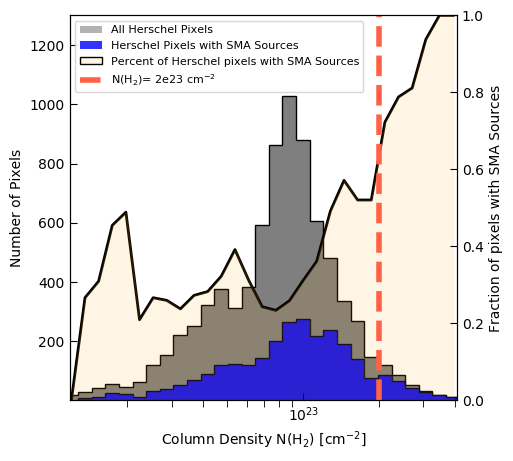

In [293]:
### Make figure of column density

catalog = table_hdu[1].data[scond]
column_file = os.path.join(herschel_path, 'column_properunits_conv36_source_only.fits')
sma_file = os.path.join(sma_path, 'CMZoom_continuum_mosaic_without_sgra_pb_corrected_new.fits')
sma_mosaic = fits.open(sma_file)
sma_orig = sma_mosaic[0].data
sma_observed = np.isfinite(sma_orig)

smaobserved_projto_herschel,_ = reproject.reproject_interp((sma_observed,
                                                            wcs.WCS(sma_mosaic[0].header).celestial),
                                                           column_fh[0].header)
smaobserved_projto_herschel[np.isnan(smaobserved_projto_herschel)] = 0
smaobserved_projto_herschel = smaobserved_projto_herschel.astype('bool')
colwcs = wcs.WCS(column_fh[0].header)
pix = colwcs.wcs_world2pix(catalog['glon'], catalog['glat'], 0)
column_dens = column_fh[0].data[pix[1].astype('int'), pix[0].astype('int')]

# column density file handle
column_fh = fits.open(column_file)
column_masked = column_fh[0].data
column_masked[~smaobserved_projto_herschel] = np.nan

sb2_mask = pyregion.open(os.path.join('/Users/hph/Dropbox/CMZoom_Data/prototype_catalog/', 
                                      'sgrb2mask.reg')).get_mask(column_fh[0])

colmin = np.nanmin(column_masked[~sb2_mask])
colmax = np.nanmax(column_masked[~sb2_mask])


smasourcemask = np.zeros_like(smaobserved_projto_herschel, dtype='bool')

# for each source, "mask" a region that is within a herschel beam as "this region contains a source"
herschel_beamsize_pixels = (25*u.arcsec / np.mean(wcs.utils.proj_plane_pixel_scales(colwcs)*u.deg)).decompose()

# make a small radial mask
npix = int(np.ceil(herschel_beamsize_pixels))
yy,xx = np.indices([npix*2]*2, dtype='float')
rad = ((yy-npix+0.5)**2 + (xx-npix+0.5)**2)**0.5
radmask = rad < herschel_beamsize_pixels

pb = ProgressBar(len(catalog))
for row,(cx,cy) in zip(catalog, zip(*pix)):
    cy = int(np.round(cy))
    cx = int(np.round(cx))
    smasourcemask[cy-npix:cy+npix,cx-npix:cx+npix][radmask] = True
    pb.update()

plt.close()
plt.rcParams.update(plt.rcParamsDefault)
#plt.style.use('seaborn-colorblind')
#sns.set_style("whitegrid", {'axes.grid' : False})
plt.rcParams.update({'font.size': 16}) #set fontsize

# Plot Histogram
plt.rcParams.update({'font.size': 10}) #set fontsize
histfig = plt.figure(3,figsize=(5,5))
histfig.clf()
ax = histfig.gca()
plt.ylabel('Number of Pixels')
plt.xlabel('Column Density N(H$_2$) [cm$^{-2}$]')
#plt.legend(loc='upper left', shadow=False, fontsize=18)

numbin = 30

#bins = np.logspace(22.9,23.9,100)
linbins = np.linspace(colmin, colmax,100)
logbins = np.logspace(np.log10(colmin), np.log10(colmax),numbin)
h1,l1,p1 = ax.hist(column_masked[np.isfinite(column_masked) & ~sb2_mask],
                   logbins, color='black',alpha=0.5, log=False,
                   label='Full cloud')
h1,l1,p1 = ax.hist(column_masked[np.isfinite(column_masked) & ~sb2_mask],
                   logbins, color='black',alpha=1.0, log=False,histtype='step')
h2,l2,p2 = ax.hist(column_masked[smasourcemask & np.isfinite(column_masked) &
                                 ~sb2_mask], logbins, alpha=.85, log=False, color='blue',
                   label='SMA Sources')
h2,l2,p2 = ax.hist(column_masked[smasourcemask & np.isfinite(column_masked) &
                                 ~sb2_mask], logbins, alpha=.85, log=False, color='k', histtype='step')

ax3 = ax.twinx()
midpts = (l1[:-1] + l1[1:])/2.
p3 = line_frac = ax3.plot(midpts, h2/h1, linestyle='-', color='k', 
                     linewidth=2.0, zorder=-21,label='Fraction of pixels with SMA Sources')
ax3.set_ylabel("Fraction of pixels with SMA Sources")
ax3.set_ylim(0,1)
fill = ax3.fill_between(midpts,h2/h1, color='orange',alpha=0.1)
ax3.set_label('Fraction of pixels with SMA Sources')
#ax.legend(line_frac,'Fraction of pixels with SMA Sources')
#ax3.legend(loc='upper right', shadow=False, fontsize=18)

vx, vy = [2e23,2e23],[0,1]

p4 = ax3.plot(vx,vy,linestyle='--',linewidth=4.0,color='tomato', label='N(H$_2$)= 2e23 cm$^{-2}$')
ax.set_xscale("log")


ax.set_xlim(1.18e22, colmax-1e22)

ax.set_ylim(1,1300)
#plt.gcf().subplots_adjust(bottom=0.2) #make room for x-axis
ax.tick_params(axis='both',which='major',direction='in',length=5)
ax.tick_params(axis='both',which='minor',direction='out',length=5)
ax3.tick_params(axis='both',which='major',direction='in',length=5)

#labs = [h1.get_label(),h2.get_label(),p3.get_label(),p4.get_label()]
plt.rcParams.update({'font.size': 8})
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='k',alpha=0.3, edgecolor='None',
                         label='All Herschel Pixels'),
                   Patch(facecolor='b',alpha=0.8, edgecolor='None',
                         label='Herschel Pixels with SMA Sources'),
                   Patch(facecolor='#FEF5E7',alpha=0.99, edgecolor='k',
                         label='Percent of Herschel pixels with SMA Sources'),
                   Line2D([0], [0], color='tomato', lw=4, ls='--', label='N(H$_2$)= 2e23 cm$^{-2}$')]

ax.legend(handles=legend_elements, loc='upper left')

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'column_histograms_log'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')

plt.show()

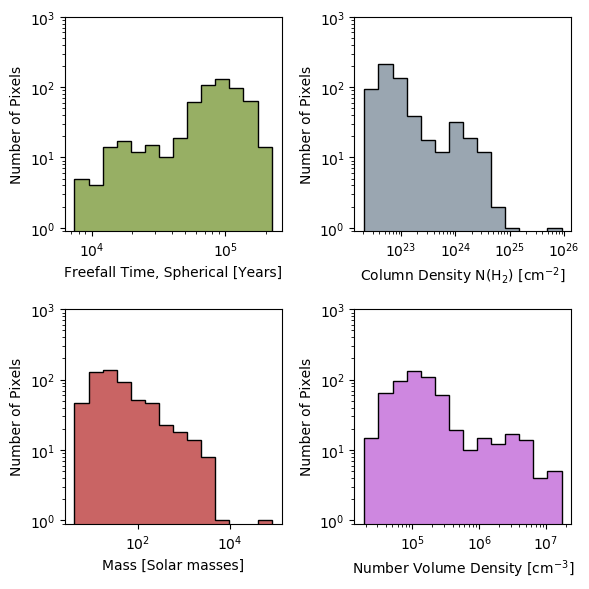

In [282]:

### Plot Histograms
tff_scond = tff_spherical[scond]
Column_N_scond = Column_N[scond]
mass_scond = mass[scond]
Vol_n_scond = Vol_n[scond]
#
plt.close()
plt.rcParams.update(plt.rcParamsDefault)
#plt.rcParams.update({'font.size': 16}) #set fontsize
fig, axarr = plt.subplots(ncols=2,nrows=2,figsize=(6,6))
###
axarr[0,0].set_ylabel('Number of Pixels')
axarr[0,0].set_xlabel('Freefall Time, Spherical [Years]')

tffmin = min(tff_scond)
tffmax = max(tff_scond)
tff_logbins = np.logspace(np.log10(tffmin), np.log10(tffmax),15)
h1,l1,p1 = axarr[0,0].hist(tff_scond,
                   tff_logbins, color='olivedrab',alpha=0.7, log=True,
                   label='SMA Clumps')
h1,l1,p1 = axarr[0,0].hist(tff_scond,
                   tff_logbins, color='k',alpha=1.0,histtype='step', log=True)

axarr[0,0].set_xscale("log")
axarr[0,0].set_ylim(0.9,1000)
####
axarr[0,1].set_ylabel('Number of Pixels')
axarr[0,1].set_xlabel('Column Density N(H$_2$) [cm$^{-2}$]')

Nmin= min(Column_N_scond)
Nmax= max(Column_N_scond)
N_logbins = np.logspace(np.log10(Nmin), np.log10(Nmax),15)
h1,l1,p1 = axarr[0,1].hist(Column_N_scond,
                   N_logbins, color='slategrey',alpha=0.7, log=True,
                   label='SMA Clumps')
h1,l1,p1 = axarr[0,1].hist(Column_N_scond,
                   N_logbins, color='k',alpha=1.0,histtype='step', log=True)

axarr[0,1].set_xscale("log")
axarr[0,1].set_ylim(0.9,1000)
####
axarr[1,0].set_ylabel('Number of Pixels')
axarr[1,0].set_xlabel('Mass [Solar masses]')


massmin = min(mass_scond)
massmax = max(mass_scond)
logbins = np.logspace(np.log10(massmin), np.log10(massmax),15)
h12,l1,p1 = axarr[1,0].hist(mass_scond,
                   logbins, color='firebrick',alpha=0.7, log=True,
                   label='SMA Clumps')
h12,l1,p1 = axarr[1,0].hist(mass_scond,
                   logbins, color='k',alpha=1.0,histtype='step', log=True)

axarr[1,0].set_xscale("log")
axarr[1,0].set_ylim(0.9,1000)
####
# axarr[1,1].set_ylabel('Number of Pixels')
# axarr[1,1].set_xlabel('Effective Radius [pc]')
# reffmin, reffmax = min(r_eff_pc), max(r_eff_pc)
# reff_linbins = np.linspace(reffmin, reffmax,15)
# h1,l1,p1 = axarr[1,1].hist(r_eff_pc,
#                    reff_linbins, color='mediumorchid',alpha=0.7, log=True,
#                    label='SMA Clumps')
# h1,l1,p1 = axarr[1,1].hist(r_eff_pc,
#                    reff_linbins, color='k',alpha=1.0,histtype='step', log=True)

#axarr[1,1].set_xscale("log")
####
####
axarr[1,1].set_ylabel('Number of Pixels')
axarr[1,1].set_xlabel('Number Volume Density [cm$^{-3}$]')
nmin = min(Vol_n_scond)
nmax = max(Vol_n_scond)
n_logbins = np.logspace(np.log10(nmin), np.log10(nmax),15)
h1,l1,p1 = axarr[1,1].hist(Vol_n_scond,
                   n_logbins, color='mediumorchid',alpha=0.7, log=True,
                   label='SMA Clumps')
h1,l1,p1 = axarr[1,1].hist(Vol_n_scond,
                   n_logbins, color='k',alpha=1.0,histtype='step', log=True)

axarr[1,1].set_xscale("log")
axarr[1,1].set_ylim(0.9,1000)
####

plt.tight_layout()

#legend = plt.legend(loc='upper left', shadow=False, fontsize=18)#'x-large')

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'histogram_4panel'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()

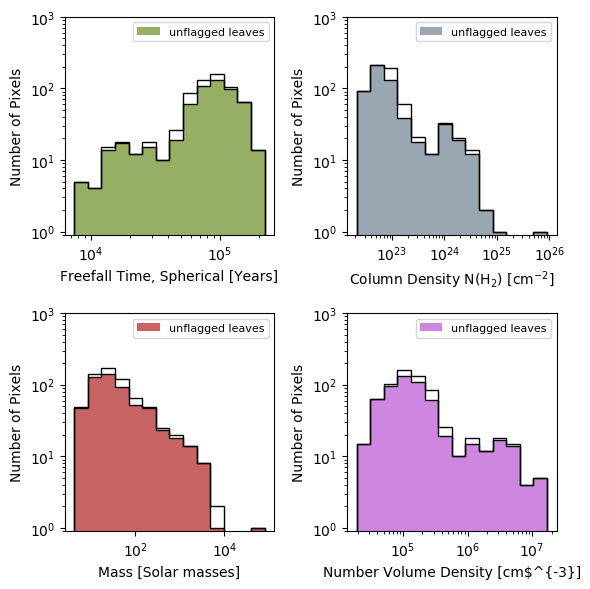

In [296]:
#########################################################
### Histograms but with radius separation
#########################################################
rlim = 0.12
rcond = scond
nrcond = nscond

plt.close()
plt.rcParams.update(plt.rcParamsDefault)
#plt.rcParams.update({'font.size': 16}) #set fontsize
fig, axarr = plt.subplots(ncols=2,nrows=2,figsize=(6,6))
###
axarr[0,0].set_ylabel('Number of Pixels')
axarr[0,0].set_xlabel('Freefall Time, Spherical [Years]')

tffmin, tffmax = min(tff_arr), max(tff_arr)
tff_logbins = np.logspace(np.log10(tffmin), np.log10(tffmax),15)
h1,l1,p1 = axarr[0,0].hist(tff[rcond],
                   tff_logbins, color='olivedrab',alpha=0.7, log=True,
                   label='unflagged leaves')
h1,l1,p1 = axarr[0,0].hist(tff[rcond],
                   tff_logbins, color='k',alpha=1.0,histtype='step', log=True)
# h1,l1,p1 = axarr[0,0].hist(tff,
#                    tff_logbins, color='k',alpha=0.5, log=True,
#                    label='r > '+str(rlim))
h1,l1,p1 = axarr[0,0].hist(tff,
                   tff_logbins, color='k',alpha=1.0,histtype='step', log=True)

axarr[0,0].set_xscale("log")
axarr[0,0].legend(loc='best', shadow=False, fontsize=8)
axarr[0,0].set_ylim(0.9,1000)
####
axarr[0,1].set_ylabel('Number of Pixels')
axarr[0,1].set_xlabel('Column Density N(H$_2$) [cm$^{-2}$]')

Nmin, Nmax = min(Column_N[rcond]), max(Column_N[rcond])
N_logbins = np.logspace(np.log10(Nmin), np.log10(Nmax),15)

h1,l1,p1 = axarr[0,1].hist(Column_N[rcond],
                   N_logbins, color='slategrey',alpha=0.7, log=True,
                   label='unflagged leaves')
h1,l1,p1 = axarr[0,1].hist(Column_N[rcond],
                   N_logbins, color='k',alpha=1.0,histtype='step', log=True)
# h1,l1,p1 = axarr[0,1].hist(Column_N,
#                    N_logbins, color='k',alpha=0.2, log=True,
#                    label='r > '+str(rlim))
h1,l1,p1 = axarr[0,1].hist(Column_N,
                   N_logbins, color='k',alpha=1.0,histtype='step', log=True)

axarr[0,1].set_xscale("log")
axarr[0,1].legend(loc='best', shadow=False, fontsize=8)
axarr[0,1].set_ylim(0.9,1000)

####
axarr[1,0].set_ylabel('Number of Pixels')
axarr[1,0].set_xlabel('Mass [Solar masses]')


massmin, massmax = min(mass[rcond]), max(mass[rcond])
logbins = np.logspace(np.log10(massmin), np.log10(massmax),15)
h12,l1,p1 = axarr[1,0].hist(mass[rcond],
                   logbins, color='firebrick',alpha=0.7, log=True,
                   label='unflagged leaves')
h12,l1,p1 = axarr[1,0].hist(mass[rcond],
                   logbins, color='k',alpha=1.0,histtype='step', log=True)
# h12,l1,p1 = axarr[1,0].hist(mass,
#                    logbins, color='k',alpha=0.2, log=True,
#                    label='r > '+str(rlim))
h12,l1,p1 = axarr[1,0].hist(mass,
                   logbins, color='k',alpha=1.0,histtype='step', log=True)

axarr[1,0].set_xscale("log")
axarr[1,0].legend(loc='best', shadow=False, fontsize=8)
axarr[1,0].set_ylim(0.9,1000)


axarr[1,1].set_ylabel('Number of Pixels')
axarr[1,1].set_xlabel('Number Volume Density [cm$^{-3}]')
nmin, nmax = min(Vol_n[rcond]), max(Vol_n[rcond])
n_logbins = np.logspace(np.log10(nmin), np.log10(nmax),15)
h1,l1,p1 = axarr[1,1].hist(Vol_n[rcond],
                   n_logbins, color='slategrey',alpha=0.7, log=True,
                   label='unflagged leaves')
h1,l1,p1 = axarr[1,1].hist(Vol_n[rcond],
                   n_logbins, color='k',alpha=1.0,histtype='step', log=True)
# h1,l1,p1 = axarr[1,1].hist(Vol_n,
#                    n_logbins, color='k',alpha=0.2, log=True,
#                    label='r > '+str(rlim))
h1,l1,p1 = axarr[1,1].hist(Vol_n,
                   n_logbins, color='k',alpha=1.0,histtype='step', log=True)

axarr[1,1].set_xscale("log")
axarr[1,1].legend(loc='best', shadow=False, fontsize=8)
axarr[1,1].set_ylim(0.9,1000)

####

plt.tight_layout()

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'histogram_4panel'+targetname+'scond.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()




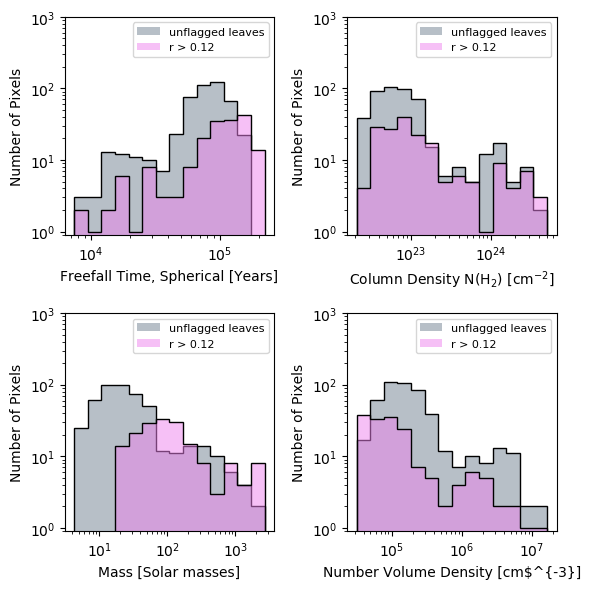

In [312]:
#########################################################
### Histograms but with radius separation
#########################################################

rlim = 0.12
rcond = r_eff_pc < rlim
nrcond = r_eff_pc >= rlim

plt.close()
plt.rcParams.update(plt.rcParamsDefault)
#plt.rcParams.update({'font.size': 16}) #set fontsize
fig, axarr = plt.subplots(ncols=2,nrows=2,figsize=(6,6))
###
axarr[0,0].set_ylabel('Number of Pixels')
axarr[0,0].set_xlabel('Freefall Time, Spherical [Years]')

tffmin, tffmax = min(tff_arr), max(tff_arr)
tff_logbins = np.logspace(np.log10(tffmin), np.log10(tffmax),15)
h1,l1,p1 = axarr[0,0].hist(tff[rcond],
                   tff_logbins, color='slategrey',alpha=0.5, log=True,
                   label='unflagged leaves')
h1,l1,p1 = axarr[0,0].hist(tff[rcond],
                   tff_logbins, color='k',alpha=1.0,histtype='step', log=True)
h1,l1,p1 = axarr[0,0].hist(tff[nrcond],
                   tff_logbins, color='violet',alpha=0.5, log=True,
                   label='r > '+str(rlim))
h1,l1,p1 = axarr[0,0].hist(tff[nrcond],
                   tff_logbins, color='k',alpha=1.0,histtype='step', log=True)

axarr[0,0].set_xscale("log")
axarr[0,0].legend(loc='best', shadow=False, fontsize=8)
axarr[0,0].set_ylim(0.9,1000)
####
axarr[0,1].set_ylabel('Number of Pixels')
axarr[0,1].set_xlabel('Column Density N(H$_2$) [cm$^{-2}$]')

Nmin, Nmax = min(Column_N[rcond]), max(Column_N[rcond])
N_logbins = np.logspace(np.log10(Nmin), np.log10(Nmax),15)

h1,l1,p1 = axarr[0,1].hist(Column_N[rcond],
                   N_logbins, color='slategrey',alpha=0.5, log=True,
                   label='unflagged leaves')
h1,l1,p1 = axarr[0,1].hist(Column_N[rcond],
                   N_logbins, color='k',alpha=1.0,histtype='step', log=True)
h1,l1,p1 = axarr[0,1].hist(Column_N[nrcond],
                   N_logbins, color='violet',alpha=0.5, log=True,
                   label='r > '+str(rlim))
h1,l1,p1 = axarr[0,1].hist(Column_N[nrcond],
                   N_logbins, color='k',alpha=1.0,histtype='step', log=True)

axarr[0,1].set_xscale("log")
axarr[0,1].legend(loc='best', shadow=False, fontsize=8)
axarr[0,1].set_ylim(0.9,1000)

####
axarr[1,0].set_ylabel('Number of Pixels')
axarr[1,0].set_xlabel('Mass [Solar masses]')


massmin, massmax = min(mass[rcond]), max(mass[rcond])
logbins = np.logspace(np.log10(massmin), np.log10(massmax),15)
h12,l1,p1 = axarr[1,0].hist(mass[rcond],
                   logbins, color='slategrey',alpha=0.5, log=True,
                   label='unflagged leaves')
h12,l1,p1 = axarr[1,0].hist(mass[rcond],
                   logbins, color='k',alpha=1.0,histtype='step', log=True)
h12,l1,p1 = axarr[1,0].hist(mass[nrcond],
                   logbins, color='violet',alpha=0.5, log=True,
                   label='r > '+str(rlim))
h12,l1,p1 = axarr[1,0].hist(mass[nrcond],
                   logbins, color='k',alpha=1.0,histtype='step', log=True)

axarr[1,0].set_xscale("log")
axarr[1,0].legend(loc='best', shadow=False, fontsize=8)
axarr[1,0].set_ylim(0.9,1000)


axarr[1,1].set_ylabel('Number of Pixels')
axarr[1,1].set_xlabel('Number Volume Density [cm$^{-3}]')
nmin, nmax = min(Vol_n[rcond]), max(Vol_n[rcond])
n_logbins = np.logspace(np.log10(nmin), np.log10(nmax),15)
h1,l1,p1 = axarr[1,1].hist(Vol_n[rcond],
                   n_logbins, color='slategrey',alpha=0.5, log=True,
                   label='unflagged leaves')
h1,l1,p1 = axarr[1,1].hist(Vol_n[rcond],
                   n_logbins, color='k',alpha=1.0,histtype='step', log=True)
h1,l1,p1 = axarr[1,1].hist(Vol_n[nrcond],
                   n_logbins, color='violet',alpha=0.5, log=True,
                   label='r > '+str(rlim))
h1,l1,p1 = axarr[1,1].hist(Vol_n[nrcond],
                   n_logbins, color='k',alpha=1.0,histtype='step', log=True)

axarr[1,1].set_xscale("log")
axarr[1,1].legend(loc='best', shadow=False, fontsize=8)
axarr[1,1].set_ylim(0.9,1000)

####

plt.tight_layout()

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'histogram_4panel'+targetname+'radius.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()




In [248]:
### Takes mass in solar masses and volume density constant in 1/cm^3 and gives radius in parsec.
def radius_from_mass_const_vol_density(Mass_solar,vol_dens):
    #print Mass_solar
    Mass = Mass_solar * (msun/1000.0)
    #print Mass
    vol_dens = vol_dens *  percm2perm
    #print vol_dens
    Radius_cubed = (Mass / (mu * mh * vol_dens)) / ((4. / 3.)*np.pi)
    #print Radius_cubed
    Radius_cm = Radius_cubed**(1./3.)
    #print Radius_cm
    Radius_pc = Radius_cm / (pc2cm/100)
    return Radius_pc


def radius_from_mass_const_col_density(Mass_solar,col_dens):
    #print Mass_solar
    Mass = Mass_solar * (msun/1000.0)
    #print Mass
    col_dens = col_dens * (10**4) #convert from cm^-2 to m^-2

    Radius_sqrd = (Mass / (mu * mh * col_dens)) / (np.pi)
    #print Radius_cubed
    Radius_cm = Radius_sqrd**(1./2.)
    #print Radius_cm
    Radius_pc = Radius_cm / (pc2cm/100)
    return Radius_pc
   
    
def mass_from_radius_const_col_density(Radius_pc,col_dens):
    Radius_cm = Radius_pc * (pc2cm)#/100) 
    Radius_sqrd = Radius_cm**2
    Mass = Radius_sqrd * (np.pi) * (mu * mh * col_dens)
    col_dens = col_dens * (10**4) #convert from cm^-2 to m^-2
    Mass_solar = Mass / (msun/1000.0)
    return Mass_solar

def planck_wave( Wave, Temp ):

    # Planck function using wavelength

    planck_conv_wave = 1.e-26 * clight / Wave**2.0

    planck = ((2.0*hplanck*clight**2.0)/(Wave**5.0))*(1.0/(np.exp((hplanck*clight)/(Wave*kboltzmann*Temp))-1.0))
    planck = planck/planck_conv_wave

    return planck

def mass_calc_submm( Wave, Temp, Kappa, Integrated_Flux, Obj_Dist ):

    Obj_Dist = Obj_Dist * pc2cm

    #from planck_func import planck_wave

    B = planck_wave( Wave, Temp )

    Mass = (Obj_Dist**2. * Integrated_Flux) / ( Kappa * B )

    Mass = Mass / msun

    return Mass

def flux_calc_submm( Wave, Temp, Kappa, Mass, Obj_Dist ):
    
    Mass = Mass * msun
    
    Obj_Dist = Obj_Dist * pc2cm

    #from planck_func import planck_wave

    B = planck_wave( Wave, Temp )
    
    Integrated_Flux = (Mass*Kappa*B)/(Obj_Dist**2.)

    return Integrated_Flux


(2,)
(2,)


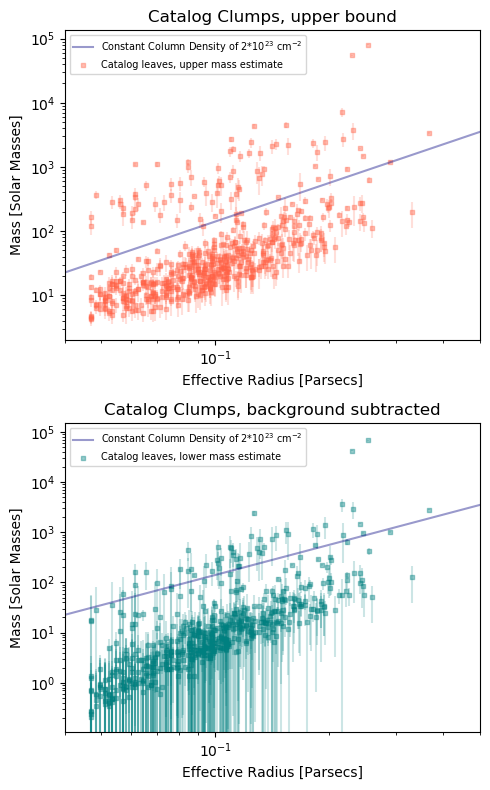

In [315]:
## side by side
plt.rcParams.update({'font.size': 10}) #set fontsize
noise_mass_arr = np.array(noise_mass)[scond]
mass_arr=np.array(mass)[scond]
mass_bgsub_arr = np.array(mass_bgsub)[scond]
r_eff_pc_arr = np.array(r_eff_pc)[scond]

#radius_vals = radius_from_mass_const_col_density(mass,2.1*10**23)
mass_bin = np.array([min(mass_arr),max(mass_arr)])
print( mass_bin.shape)
radius_vals = radius_from_mass_const_col_density(mass_bin,2.0*10**23)
print( radius_vals.shape)

f = plt.figure(figsize=(5,8))

#plt.xlabel('Effective Radius [Parsecs]')
#plt.ylabel('Mass [Solar Masses]')

ax1 = f.add_subplot(211)
ax1.set_title('Catalog Clumps, upper bound')
ax1.scatter(r_eff_pc_arr, mass_arr,s=10, color='tomato',alpha=0.4,marker='s',label='Catalog leaves, upper mass estimate')
ax1.plot(radius_vals,mass_bin,color='navy',label='Constant Column Density of 2*10$^{23}$ cm$^{-2}$',alpha=0.4)
ax1.errorbar(x=r_eff_pc_arr, y=mass_arr, yerr=noise_mass_arr, ls='none',color='tomato',alpha=0.2)

legend = ax1.legend(loc='upper left', shadow=False, fontsize=7)#'x-large')

ax1.set_xlabel('Effective Radius [Parsecs]')
ax1.set_ylabel('Mass [Solar Masses]')
ax1.set_xlim(4e-2,0.5)

ax2 = f.add_subplot(212)
ax2.set_title('Catalog Clumps, background subtracted')
ax2.scatter(r_eff_pc_arr,mass_bgsub_arr, s=10, color='teal',alpha=.4,marker='s',label='Catalog leaves, lower mass estimate')
ax2.plot(radius_vals,mass_bin,color='navy',label='Constant Column Density of 2*10$^{23}$ cm$^{-2}$',alpha=0.4)
ax2.errorbar(x=r_eff_pc_arr, y=mass_bgsub_arr, yerr=noise_mass_arr, ls='none',color='teal',alpha=0.2)
legend = ax2.legend(loc='upper left', shadow=False, fontsize=7)#'x-large')

ax2.set_xlabel('Effective Radius [Parsecs]')
ax2.set_ylabel('Mass [Solar Masses]')
#ax2.set_ylim(1e-2,2e5)
ax2.set_xlim(4e-2,0.5)


ax1.set_xscale("log")
ax1.set_yscale("log")
ax2.set_xscale("log")
ax2.set_yscale("log")

#plt.gcf().subplots_adjust(bottom=0.2) #make room for x-axis


plt.tight_layout()

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'twofig_subtracted_mass_radius'+targetname+'.pdf',
            format='pdf', dpi=100, bbox_inches='tight')
plt.show()

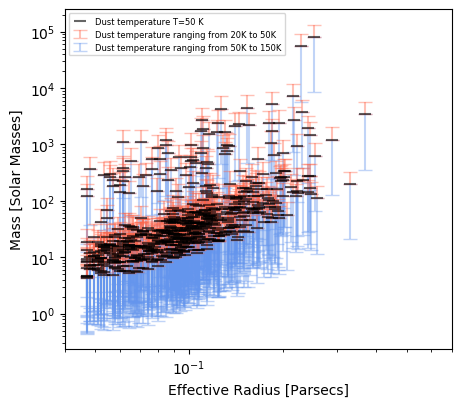

In [311]:

plt.rcParams.update({'font.size': 10}) #set fontsize
mrfig = plt.figure(3,figsize=(5,5))
mrfig.clf()
ax = mrfig.gca()
plt.xlabel('Effective Radius [Parsecs]')
plt.ylabel('Mass [Solar Masses]')
#print mass
def mass_from_radius_const_col_density(Radius_pc,col_dens):
    Radius_cm = Radius_pc * (pc2cm/100) 
    col_dens = col_dens * (10**4) #convert from cm^-2 to m^-2
    Radius_sqrd = Radius_cm**2
    Mass = Radius_sqrd * (np.pi) * (mu * mh * col_dens)
    
    Mass_solar = Mass / (msun/1000.0)
    return Mass_solar

#for i in range(len(mass)):
#    ax.plot([r_eff_pc[i],r_eff_pc[i]],[mass_bgsub[i],mass[i]],'k-',linewidth='0.2')


### plot temp bar
low_dustTemp = 20
mid_dustTemp = 50
high_dustTemp = 150
#flux = table_hdu[1].data['flux_integrated']
#flux_vals_mid_1 = flux_calc_submm(Wave,mid_dustTemp,Kappa,mass_vals_1,distance)
#flux_vals_mid = flux_calc_submm(Wave,mid_dustTemp,Kappa,mass,distance)
#mass_vals_mid_1 = mass_calc_submm(Wave, mid_dustTemp, Kappa, flux_vals_mid_1, distance)
mass_vals_mid = mass_calc_submm(Wave, mid_dustTemp, Kappa, flux_integrated, distance)

#flux_vals_high_1 = flux_calc_submm(Wave,high_dustTemp,Kappa,mass_vals_1,distance)
#flux_vals_high = flux_calc_submm(Wave,high_dustTemp,Kappa,mass,distance)
#mass_vals_high_1 = mass_calc_submm(Wave,low_dustTemp, Kappa, flux_vals_high_1, distance)
mass_vals_high = mass_calc_submm(Wave,high_dustTemp, Kappa, flux_integrated, distance)
mass_diff_mid = mass_vals_mid - mass
mass_diff_high = mass_vals_high - mass

'''
flux1 = .03
flux2 = .1
flux3 = 2.
flux4 = 1.
#print flux
#print flux.shape
lowTmass =mass_calc_submm(Wave, low_dustTemp, Kappa, flux2, distance)
highTmass1 = mass_calc_submm(Wave, 50., Kappa, flux2, distance)
highTmass2 = mass_calc_submm(Wave, 100., Kappa, flux2, distance)
highTmass3 = mass_calc_submm(Wave, 150., Kappa, flux2, distance)
highTmass4 = mass_calc_submm(Wave, 200., Kappa, flux2, distance)
'''

#ax.fill_between(r_bound_vals,mass_vals_2,mass_vals_mid_2,color='green',alpha=0.3)
#ax.fill_between(r_bound_vals,mass_vals_mid_2,mass_vals_high_2,color='blue',alpha=0.3)
#ax.plot(r_bound_vals,mass_vals_high_2,color='blue')

ax.scatter(r_eff_pc, mass, color='black',alpha=.6, label='Dust temperature T=50 K',marker='_',s=80.,zorder =22)
zeros = np.zeros(shape = mass.shape)
ax.errorbar(x=r_eff_pc, y=mass, yerr=[mass_diff_mid,zeros], ls='none',color='tomato',alpha = 0.4,
            label='Dust temperature ranging from 20K to 50K',capsize=5)

ax.errorbar(x=r_eff_pc, y=mass, yerr=[zeros,mass_diff_high], ls='none',color='cornflowerblue',alpha = 0.4,
            label='Dust temperature ranging from 50K to 150K',capsize=5, zorder=1)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(4.0e-2,0.7)

plt.gcf().subplots_adjust(bottom=0.2) #make room for x-axis

legend = plt.legend(loc='upper left', shadow=False, fontsize=6)#'x-large')


# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'MR_temp_bar'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()